In [ ]:
import torch
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# Check for GPU
torch.cuda.is_available()

False

In [ ]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Count number of devices
torch.cuda.device_count()

0

In [ ]:
# Create tensor (default on CPU)
tensor = torch.tensor([1, 2, 3])

# Tensor not on GPU
print(tensor, tensor.device)

# Move tensor to GPU (if available)
tensor_on_gpu = tensor.to(device)
tensor_on_gpu

# Notice the second tensor has device='cuda:0'
# This means it's stored on the 0th GPU available (GPUs are 0 indexed, if two GPUs were available, they'd be 'cuda:0' and 'cuda:1' respectively, up to 'cuda:n').

tensor([1, 2, 3]) cpu


tensor([1, 2, 3])

In [ ]:
# If tensor is on GPU, can't transform it to NumPy (this will error)
tensor_on_gpu.numpy()

array([1, 2, 3])

In [ ]:
# Instead, copy the tensor back to cpu
tensor_back_on_cpu = tensor_on_gpu.cpu().numpy()
tensor_back_on_cpu

array([1, 2, 3])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                    dtype=torch.float), # <- PyTorch loves float32 by default
                                    requires_grad=True) # <- can we update this value with gradient descent? -> True)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                dtype=torch.float),
                                requires_grad=True)

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

In [ ]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(10)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([-0.6014], requires_grad=True),
 Parameter containing:
 tensor([-1.0122], requires_grad=True)]

In [ ]:
#We can also get the state (what the model contains) of the model using .state_dict()

# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([-0.6014])), ('bias', tensor([-1.0122]))])

In [ ]:
# Create dataset
true_weight = 0.7
true_bias = 0.3

X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
y = true_weight * X + true_bias

# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

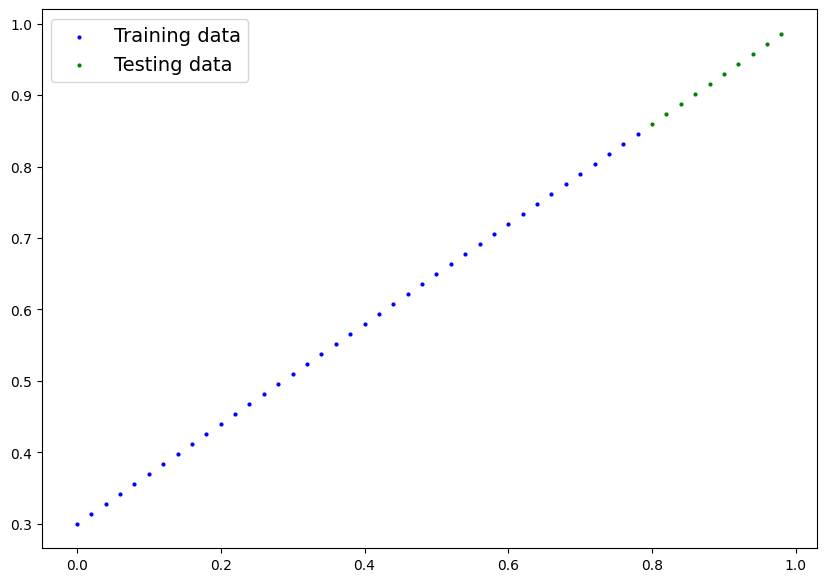

In [ ]:
plot_predictions()

In [ ]:
# Making predictions using torch.inference_mode()
with torch.inference_mode():
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

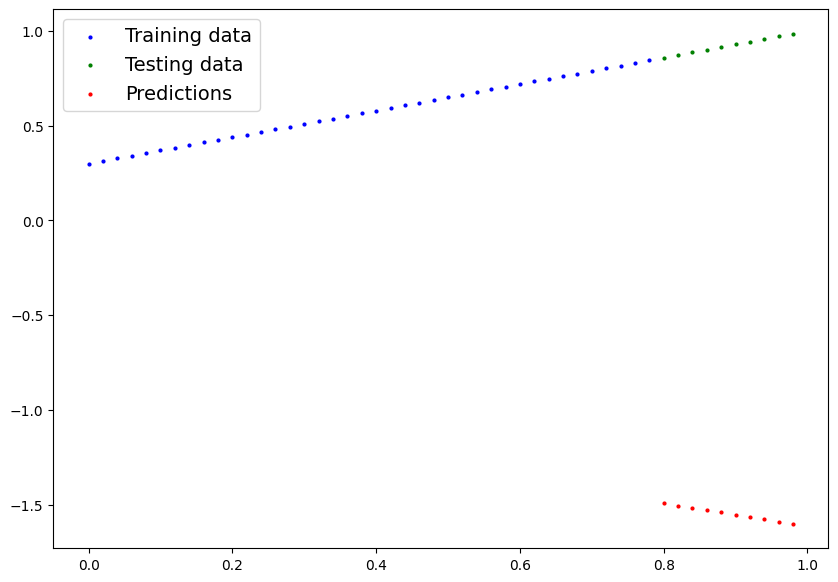

In [ ]:
plot_predictions(predictions=y_preds)

As the name suggests, torch.inference_mode() is used when using a model for inference (making predictions).

torch.inference_mode() turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the forward() method) faster.

Note: In older PyTorch code, you may also see torch.no_grad() being used for inference. While torch.inference_mode() and torch.no_grad() do similar things, torch.inference_mode() is newer, potentially faster and preferred.

In [ ]:
# Training phase

# Create the loss function
loss = nn.MSELoss() # MSE loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01)
# learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

In [ ]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 500

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss_value = loss(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss_value.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss_value.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MSE Train Loss: {loss_value} | MSE Test Loss: {test_loss} ")

Epoch: 0 | MSE Train Loss: 3.401771068572998 | MSE Test Loss: 5.862760066986084 
Epoch: 10 | MSE Train Loss: 2.1359572410583496 | MSE Test Loss: 3.913177013397217 
Epoch: 20 | MSE Train Loss: 1.344064712524414 | MSE Test Loss: 2.6476032733917236 
Epoch: 30 | MSE Train Loss: 0.8486032485961914 | MSE Test Loss: 1.8197206258773804 
Epoch: 40 | MSE Train Loss: 0.5385570526123047 | MSE Test Loss: 1.2733302116394043 
Epoch: 50 | MSE Train Loss: 0.34448719024658203 | MSE Test Loss: 0.9090636372566223 
Epoch: 60 | MSE Train Loss: 0.22296099364757538 | MSE Test Loss: 0.6634597778320312 
Epoch: 70 | MSE Train Loss: 0.1468120664358139 | MSE Test Loss: 0.4957999289035797 
Epoch: 80 | MSE Train Loss: 0.09904823452234268 | MSE Test Loss: 0.3798120617866516 
Epoch: 90 | MSE Train Loss: 0.06904121488332748 | MSE Test Loss: 0.2984338402748108 
Epoch: 100 | MSE Train Loss: 0.050143174827098846 | MSE Test Loss: 0.2405000627040863 
Epoch: 110 | MSE Train Loss: 0.03819595277309418 | MSE Test Loss: 0.198640

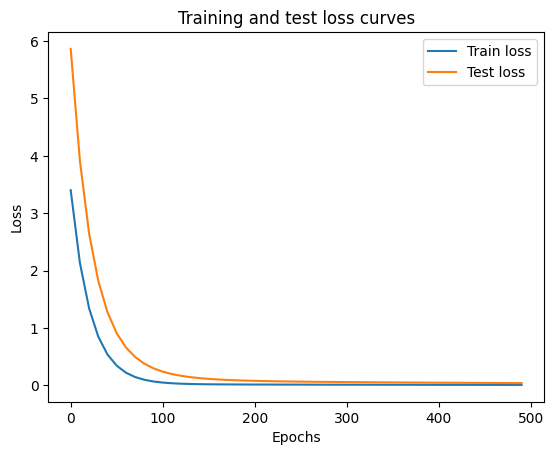

In [ ]:
# Plot the loss values curve
import matplotlib.pyplot as plt
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()


In [ ]:
# Re-show params
list(model_0.parameters())

[Parameter containing:
 tensor([0.2862], requires_grad=True),
 Parameter containing:
 tensor([0.4691], requires_grad=True)]

In [ ]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.6981],
        [0.7038],
        [0.7095],
        [0.7153],
        [0.7210],
        [0.7267],
        [0.7324],
        [0.7382],
        [0.7439],
        [0.7496]])

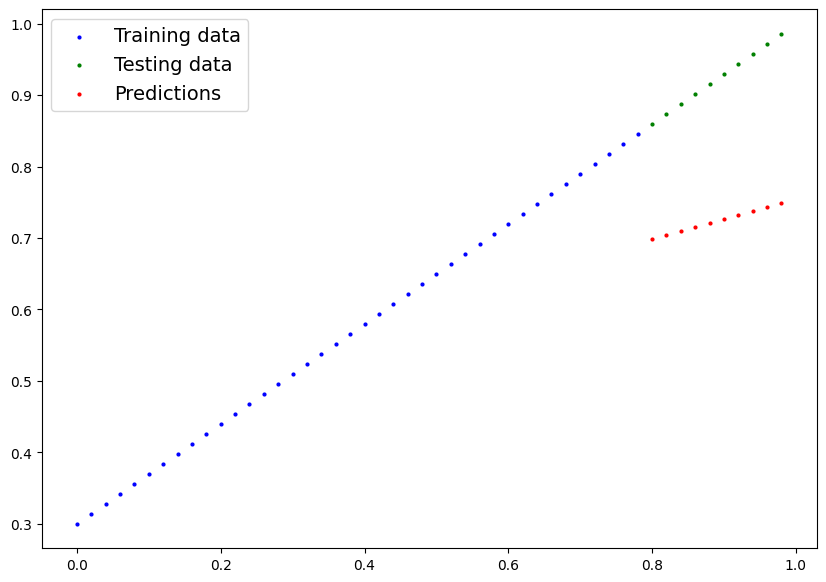

In [ ]:
# Visualize result
plot_predictions(predictions=y_preds)

In [ ]:
# Save model
model_0.state_dict()

OrderedDict([('weights', tensor([0.2862])), ('bias', tensor([0.4691]))])

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth


-rw-r--r-- 1 root root 1680 Feb  5 05:48 models/01_pytorch_workflow_model_0.pth


In [ ]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<ipython-input-52-c3119fcaa06c>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [ ]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.2862])), ('bias', tensor([0.4691]))])

In [ ]:
# Check model device
next(loaded_model_0.parameters()).device

device(type='cpu')

In [ ]:
# # Set model to GPU if it's available, otherwise it'll default to CPU
loaded_model_0.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(loaded_model_0.parameters()).device

NameError: name 'device' is not defined